In [182]:
!pip install backtesting

  Obtaining dependency information for backtesting from https://files.pythonhosted.org/packages/8d/93/399248543781d93d3adac409ee16708942ba6e9693577c3ecff0964d092d/backtesting-0.6.4-py3-none-any.whl.metadata
  Obtaining dependency information for bokeh!=3.0.*,!=3.2.*,>=1.4.0 from https://files.pythonhosted.org/packages/76/d2/5f2a3c80ab897eaccd15cc89aaebec2bf8b91bc8314fe9e43cf04d6e9edd/bokeh-3.7.2-py3-none-any.whl.metadata
  Obtaining dependency information for contourpy>=1.2 from https://files.pythonhosted.org/packages/e6/75/3469f011d64b8bbfa04f709bfc23e1dd71be54d05b1b083be9f5b22750d1/contourpy-1.3.2-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for narwhals>=1.13 from https://files.pythonhosted.org/packages/80/b3/5781eb874f04cb1e882a7d93cf30abcb00362a3205c5f3708a7434a1a2ac/narwhals-1.35.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.4/191.4 kB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 M

In [159]:
import pandas as pd
import os
import numpy as np
from ta import add_all_ta_features
from ta.trend import EMAIndicator, MACD
from ta.momentum import RSIIndicator, StochasticOscillator, ROCIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, VolumeWeightedAveragePrice
from ta.utils import dropna
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from xgboost import plot_importance
from xgboost import plot_tree as pt
import shap
import xgboost as xgb

In [ ]:
#load data
df = pd.read_csv('./archive/sp500_stocks.csv', sep=',')
df = dropna(df)

company_df = pd.read_csv('./archive/sp500_companies.csv', sep=',')
companies = company_df["Symbol"]
#print(companies)
companies = companies.tolist
#print(companies)

company_split = {company: df[df["Symbol"] == company] for company in df["Symbol"].unique()}
for group, sub_df in company_split.items():
    
    print(f"Group {group}:\n{sub_df}\n")

    # Exponential Moving Averages
    ema15 = EMAIndicator(close=sub_df["Close"], window=15).ema_indicator()
    ema50 = EMAIndicator(close=sub_df["Close"], window=50).ema_indicator()
    sub_df["ema15"] = ema15
    sub_df["ema50"] = ema50

    # MACD
    macd = MACD(close=sub_df["Close"], window_slow=26, window_fast=12, window_sign=9)
    sub_df['macd'] = macd.macd()
    sub_df['macd_signal'] = macd.macd_signal()

    # Bollinger Bands
    bb = BollingerBands(close=sub_df["Close"], window=20, window_dev=2)
    sub_df['bb_bbm'] = bb.bollinger_mavg()
    sub_df['bb_bbh'] = bb.bollinger_hband()
    sub_df['bb_bbl'] = bb.bollinger_lband()

    # RSI
    rsi = RSIIndicator(close=sub_df["Close"], window=14).rsi()
    sub_df["rsi"] = rsi

    # Stochastic Oscillator
    sto_osc = StochasticOscillator(high=sub_df["High"], low=sub_df["Low"], close=sub_df["Close"], window=14, smooth_window=3)
    sub_df["stoch_k"] = sto_osc.stoch()
    sub_df["stoch_d"] = sto_osc.stoch_signal()

    # Average True Range
    atr = AverageTrueRange(high=sub_df["High"], low=sub_df["Low"], close=sub_df["Close"], window=14).average_true_range()
    sub_df["atr_14"] = atr

    # On Balance Volume
    obv = OnBalanceVolumeIndicator(close=sub_df["Close"], volume=sub_df["Volume"]).on_balance_volume()
    sub_df["obv"] = obv

    # Volume Weighted Average Price
    vwap = VolumeWeightedAveragePrice(high=sub_df["High"], low=sub_df["Low"], close=sub_df["Close"], volume=sub_df["Volume"]).volume_weighted_average_price()
    sub_df["vwap"] = vwap

    # Rate of Change
    roc = ROCIndicator(close=sub_df["Close"], window=10).roc()
    sub_df["roc_10"] = roc

    # Increase
    sub_df["Target"] = (sub_df["Close"].shift(-1) > sub_df["Close"]).astype(int)

    # Clopen
    sub_df["Clopen"] = sub_df["Close"]/sub_df["Open"]

    # High/Low
    sub_df["HighLow"] = sub_df["High"]/sub_df["Low"]

    # Log Change
    sub_df["log_price"] = np.log(sub_df["Close"])
    sub_df["Log5"] = sub_df["log_price"] - sub_df["log_price"].shift(5)
    sub_df["Log15"] = sub_df["log_price"] - sub_df["log_price"].shift(15)
    sub_df["Log30"] = sub_df["log_price"] - sub_df["log_price"].shift(30)
    
    # percent change
    sub_df['Pct_Change'] = (sub_df['Close'].shift(-1) - sub_df['Close']) / sub_df['Close']

    print(sub_df.head(), group)
    sub_df.to_csv("{}.csv".format(group), index=False)


In [ ]:
stock_folder = "./clean_data"
stock_files = [f for f in os.listdir(stock_folder) if f.endswith('.csv')]
print(stock_files)
dataframes = []

for file in stock_files:
    file_path = os.path.join(stock_folder, file)
    print(file, file_path)
    df = pd.read_csv(file_path)
    df['Ticker'] = file.split('.')[0]
    dataframes.append(df)

merged_df = pd.concat(dataframes, ignore_index=True)
merged_df.to_csv('merged_data.csv', index=False)

['CSCO.csv', 'UAL.csv', 'ISRG.csv', 'CE.csv', 'VRTX.csv', 'EQIX.csv', 'PODD.csv', 'V.csv', 'FOX.csv', 'MO.csv', 'ENPH.csv', 'EIX.csv', 'BBY.csv', 'HCA.csv', 'AJG.csv', 'DTE.csv', 'C.csv', 'T.csv', 'APH.csv', 'MSI.csv', 'FCX.csv', 'ADM.csv', 'LH.csv', 'SOLV.csv', 'BLDR.csv', 'GPN.csv', 'PPG.csv', 'IRM.csv', 'IQV.csv', 'ESS.csv', 'STZ.csv', 'PARA.csv', 'TDG.csv', 'TSN.csv', 'PEP.csv', 'PEG.csv', 'DLR.csv', 'FAST.csv', 'TJX.csv', 'MRK.csv', 'ALLE.csv', 'ABBV.csv', 'ORCL.csv', 'SBUX.csv', 'IR.csv', 'DPZ.csv', 'CAT.csv', 'MCD.csv', 'AMZN.csv', 'GLW.csv', 'BDX.csv', 'CSGP.csv', 'PWR.csv', 'DXCM.csv', 'WELL.csv', 'VRSK.csv', 'FTNT.csv', 'DHI.csv', 'ED.csv', 'INVH.csv', 'IP.csv', 'EXPE.csv', 'RVTY.csv', 'WDC.csv', 'UPS.csv', 'MSFT.csv', 'ANSS.csv', 'UDR.csv', 'WEC.csv', 'UBER.csv', 'SHW.csv', 'CCL.csv', 'EA.csv', 'DE.csv', 'VLTO.csv', 'NDAQ.csv', 'RTX.csv', 'PNC.csv', 'KMX.csv', 'NVDA.csv', 'ALB.csv', 'VLO.csv', 'FDX.csv', 'DG.csv', 'HIG.csv', 'INCY.csv', 'HSIC.csv', 'AXP.csv', 'HPE.csv', 'DFS

In [180]:
stock_data = pd.read_csv('./merged_data.csv')
stock_data = stock_data.dropna()
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['Year'] = stock_data['Date'].dt.year
stock_data['Month'] = stock_data['Date'].dt.month
stock_data['Day'] = stock_data['Date'].dt.day
stock_data = stock_data.drop('Date', axis=1)
stock_data = stock_data.drop('Symbol', axis=1)
stock_data = stock_data.drop('Ticker', axis=1)
stock_data = stock_data.drop('Pct_Change', axis=1) # for the decision trees, we have to remove this
X = stock_data.drop('Target', axis=1)
y = stock_data['Target']
print(len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(len(X_train))

609224
456918


In [181]:
stock_data.head

<bound method NDFrame.head of         Adj Close      Close       High        Low       Open      Volume  \
49      17.449606  26.150000  26.340000  26.010000  26.030001  53887500.0   
50      17.523018  26.260000  26.400000  26.180000  26.200001  32456000.0   
51      17.576401  26.340000  26.430000  26.219999  26.240000  27088000.0   
52      17.449606  26.150000  26.440001  26.070000  26.370001  55661800.0   
53      17.536352  26.280001  26.379999  25.889999  25.920000  31899500.0   
...           ...        ...        ...        ...        ...         ...   
617818  32.290001  32.290001  32.570000  32.180000  32.320000   2872600.0   
617819  32.320000  32.320000  32.779999  32.299999  32.349998   4056300.0   
617820  32.259998  32.259998  32.480000  32.119999  32.160000   4166300.0   
617821  31.590000  31.590000  32.299999  31.570000  32.160000   4363500.0   
617822  32.020000  32.020000  32.290001  31.520000  31.540001   5326900.0   

            ema15      ema50      macd  macd_

In [ ]:
param_grid = {
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}

In [ ]:
dt_classifier = DecisionTreeClassifier(max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=10)
dt_classifier.fit(X_train, y_train)

y_pred = dt_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

plot_tree(dt_classifier)

train_y_pred = dt_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, train_y_pred)
print(f"Train Accuracy: {train_accuracy}")


# get the most important features
importances = dt_classifier.feature_importances_

# Rank features
feature_importance = pd.Series(importances, index=X_train.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar')

Test Accuracy: 0.5856039814583799
Train Accuracy: 0.7706612565055436


<Axes: >

Error in callback <function flush_figures at 0x177ad0a40> (for post_execute):


KeyboardInterrupt: 

Test Accuracy (RF): 0.5789922918335456
Train Accuracy (RF): 0.89336817547131
features


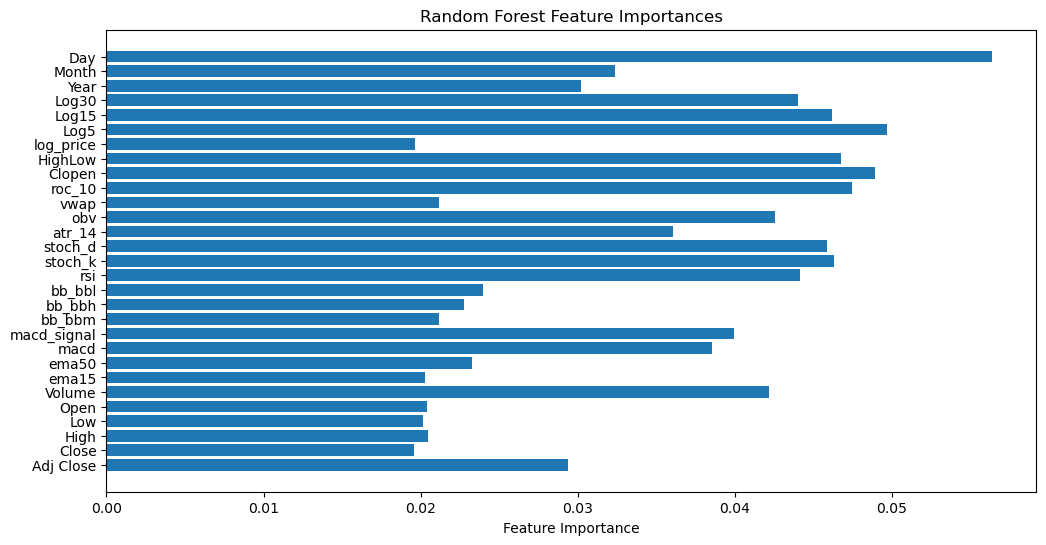

In [12]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,         # number of trees in the forest
    max_depth=20,
    max_features='sqrt',      # good default for RF
    min_samples_leaf=4,
    min_samples_split=10,
)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (RF): {test_accuracy}")

train_y_pred = rf_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, train_y_pred)
print(f"Train Accuracy (RF): {train_accuracy}")

importances = rf_classifier.feature_importances_
print("features")
features = X.columns
plt.figure(figsize=(12, 6))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()

In [79]:
stock_data = pd.read_csv('./merged_data.csv')
stock_data = stock_data.dropna()
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['Year'] = stock_data['Date'].dt.year
stock_data['Month'] = stock_data['Date'].dt.month
stock_data['Day'] = stock_data['Date'].dt.day
stock_data = stock_data.drop('Date', axis=1)
stock_data = stock_data.drop('Symbol', axis=1)
stock_data = stock_data.drop('Ticker', axis=1)
stock_data = stock_data.drop('Target', axis=1)

X = stock_data.drop(['Pct_Change'], axis=1)
y = stock_data['Pct_Change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [80]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

threshold = 0.005  # 0.5%

profitable_predictions = (y_pred > threshold)
num_trades = profitable_predictions.sum()
returns = y_test[profitable_predictions]
quants = np.quantile(returns, [0, 0.05, 0.5, .95, 1])
normalized_returns = []
for i in returns:
    if i > quants[1] and i < quants[3]:
        normalized_returns.append(i)

avg_actual_return = y_test[profitable_predictions].mean()
avg_selected_returns = sum(normalized_returns) / len(normalized_returns)

print(f"Number of selected trades: {num_trades}")
print(f"Number of middle 90% trades: {len(normalized_returns)}")
print(f"Avg return on all selected trades: {avg_actual_return:.4f}")
print(f"Avg return on filtered selected trades: {avg_selected_returns:.4f}")
print(y_test[profitable_predictions].max())
print(y_test[profitable_predictions].min())

MSE: 0.00041224929719852724
MAE: 0.0131
RMSE: 0.0203
R² Score: 0.0017
Number of selected trades: 951
Number of middle 90% trades: 855
Avg return on all selected trades: 0.0103
Avg return on filtered selected trades: 0.0100
0.2532277963749201
-0.3481308819893823


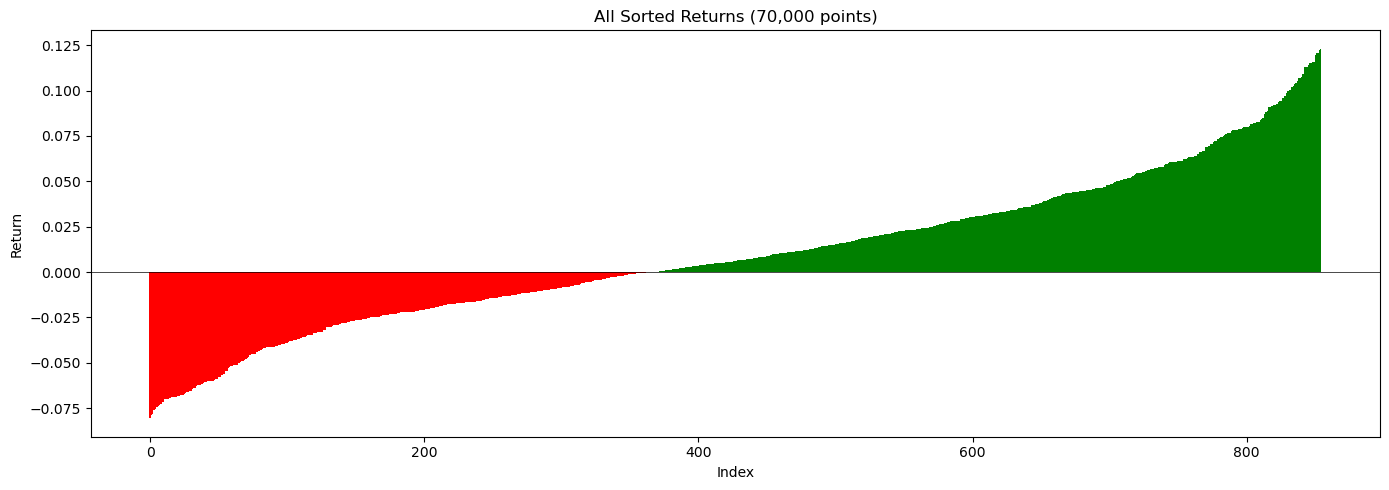

In [81]:
sorted_indices = np.argsort(normalized_returns)
sorted_returns = np.array(normalized_returns)[sorted_indices]
# Assign colors based on positive or negative value
colors = ['green' if val >= 0 else 'red' for val in sorted_returns]

# Plot
plt.figure(figsize=(14, 5))
plt.bar(np.arange(len(sorted_returns)), sorted_returns, color=colors, width=1.0)
plt.axhline(0, color='black', linewidth=0.5)
plt.title('All Sorted Returns (70,000 points)')
plt.xlabel('Index')
plt.ylabel('Return')
plt.tight_layout()
plt.show()

In [82]:
threshold = -0.005  # 0.5%

loss_predictions = (y_pred < threshold)
num_trades = loss_predictions.sum()
returns = y_test[loss_predictions]
quants = np.quantile(returns, [0, 0.05, 0.5, .95, 1])
normalized_returns = []
for i in returns:
    if i > quants[1] and i < quants[3]:
        normalized_returns.append(i)

avg_actual_return = y_test[loss_predictions].mean()
avg_selected_returns = sum(normalized_returns) / len(normalized_returns)

print(f"Number of selected losing trades: {num_trades}")
print(f"Number of middle 90% trades: {len(normalized_returns)}")
print(f"Avg return on all selected trades: {avg_actual_return:.4f}")
print(f"Avg return on filtered selected trades: {avg_selected_returns:.4f}")
print(y_test[loss_predictions].max())
print(y_test[loss_predictions].min())

Number of selected losing trades: 162
Number of middle 90% trades: 144
Avg return on all selected trades: -0.0046
Avg return on filtered selected trades: -0.0028
0.1113019849289082
-0.1888079307404959


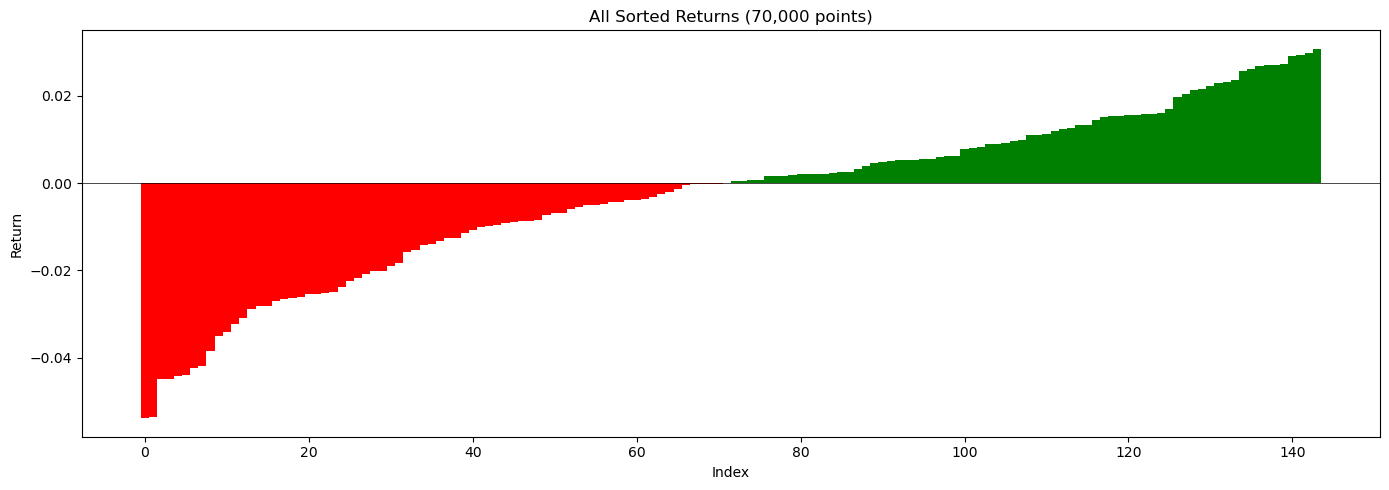

In [84]:
sorted_indices = np.argsort(normalized_returns)
sorted_returns = np.array(normalized_returns)[sorted_indices]
# Assign colors based on positive or negative value
colors = ['green' if val >= 0 else 'red' for val in sorted_returns]

# Plot
plt.figure(figsize=(14, 5))
plt.bar(np.arange(len(sorted_returns)), sorted_returns, color=colors, width=1.0)
plt.axhline(0, color='black', linewidth=0.5)
plt.title('All Sorted Returns (70,000 points)')
plt.xlabel('Index')
plt.ylabel('Return')
plt.tight_layout()
plt.show()

In [48]:
print(len(y_pred[(y_pred > 0)]))
print(len(y_pred[(y_pred < 0)]))

126661
25645


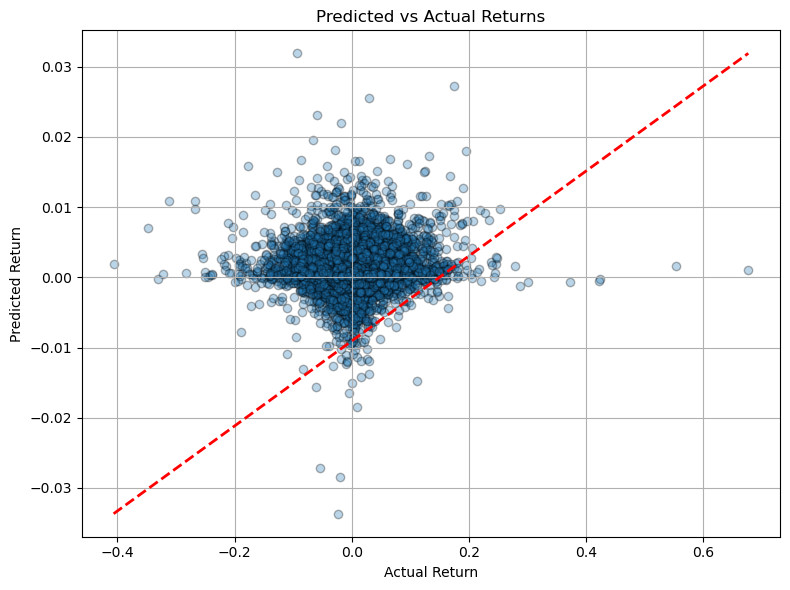

In [85]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'r--', lw=2)  # reference line
plt.xlabel("Actual Return")
plt.ylabel("Predicted Return")
plt.title("Predicted vs Actual Returns")
plt.grid(True)
plt.tight_layout()
plt.show()

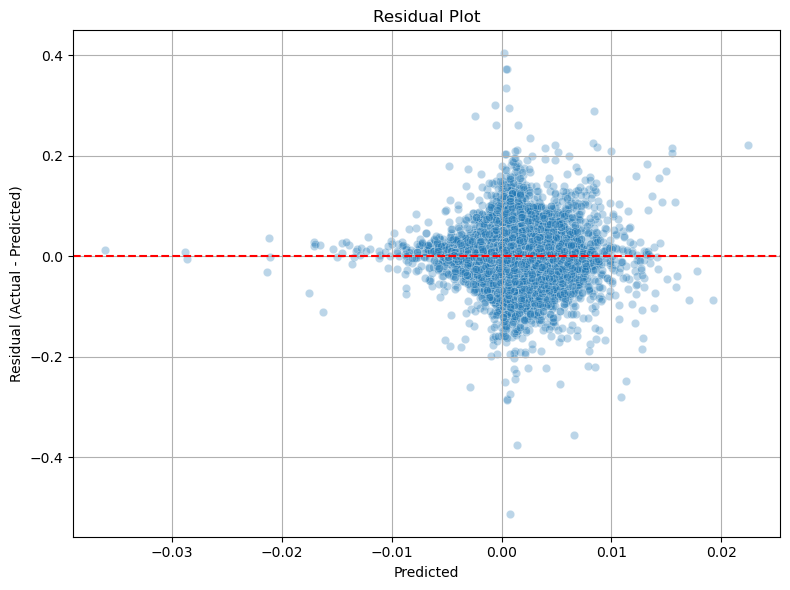

In [58]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

In [86]:
coefs = reg.coef_
feature_names = X_train.columns
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print(coef_df.head(10))

        Feature  Coefficient  Abs_Coefficient
20       Clopen    -0.039364         0.039364
21      HighLow     0.017300         0.017300
23         Log5    -0.008563         0.008563
25        Log30    -0.003943         0.003943
24        Log15    -0.001502         0.001502
3           Low     0.000714         0.000714
9   macd_signal    -0.000645         0.000645
8          macd     0.000589         0.000589
4          Open    -0.000559         0.000559
1         Close    -0.000555         0.000555


In [87]:
top_n = 10
top_features = coef_df['Feature'].head(top_n).values
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

In [88]:
lr_top = LinearRegression()
lr_top.fit(X_train_top, y_train)
y_pred_top = lr_top.predict(X_test_top)

In [89]:
mse = mean_squared_error(y_test, y_pred_top)
mae = mean_absolute_error(y_test, y_pred_top)
rmse = mean_squared_error(y_test, y_pred_top, squared=False)
r2 = r2_score(y_test, y_pred_top)
print(f"MSE: {mse}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

threshold = 0.005  # 0.5%

profitable_predictions = (y_pred_top > threshold)
num_trades = profitable_predictions.sum()
returns = y_test[profitable_predictions]
quants = np.quantile(returns, [0, 0.05, 0.5, .95, 1])
normalized_returns = []
for i in returns:
    if i > quants[1] and i < quants[3]:
        normalized_returns.append(i)

avg_actual_return = y_test[profitable_predictions].mean()
avg_selected_returns = sum(normalized_returns) / len(normalized_returns)

print(f"Number of selected trades: {num_trades}")
print(f"Number of middle 90% trades: {len(normalized_returns)}")
print(f"Avg return on all selected trades: {avg_actual_return:.4f}")
print(f"Avg return on filtered selected trades: {avg_selected_returns:.4f}")
print(y_test[profitable_predictions].max())
print(y_test[profitable_predictions].min())

MSE: 0.00041250012672828975
MAE: 0.0131
RMSE: 0.0203
R² Score: 0.0010
Number of selected trades: 438
Number of middle 90% trades: 394
Avg return on all selected trades: 0.0119
Avg return on filtered selected trades: 0.0129
0.2532277963749201
-0.3481308819893823


Now to predict the last 5 months of a stock and show performance

In [59]:
stock_data = pd.read_csv('./merged_data.csv')
stock_data = stock_data.dropna()
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['Year'] = stock_data['Date'].dt.year
stock_data['Month'] = stock_data['Date'].dt.month
stock_data['Day'] = stock_data['Date'].dt.day
stock_data = stock_data.drop('Date', axis=1)
stock_data = stock_data.drop('Symbol', axis=1)
stock_data = stock_data.drop('Ticker', axis=1)
stock_data = stock_data.drop('Target', axis=1)

X = stock_data.drop(['Pct_Change'], axis=1)
y = stock_data['Pct_Change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

MSE: 0.0003093961380119802


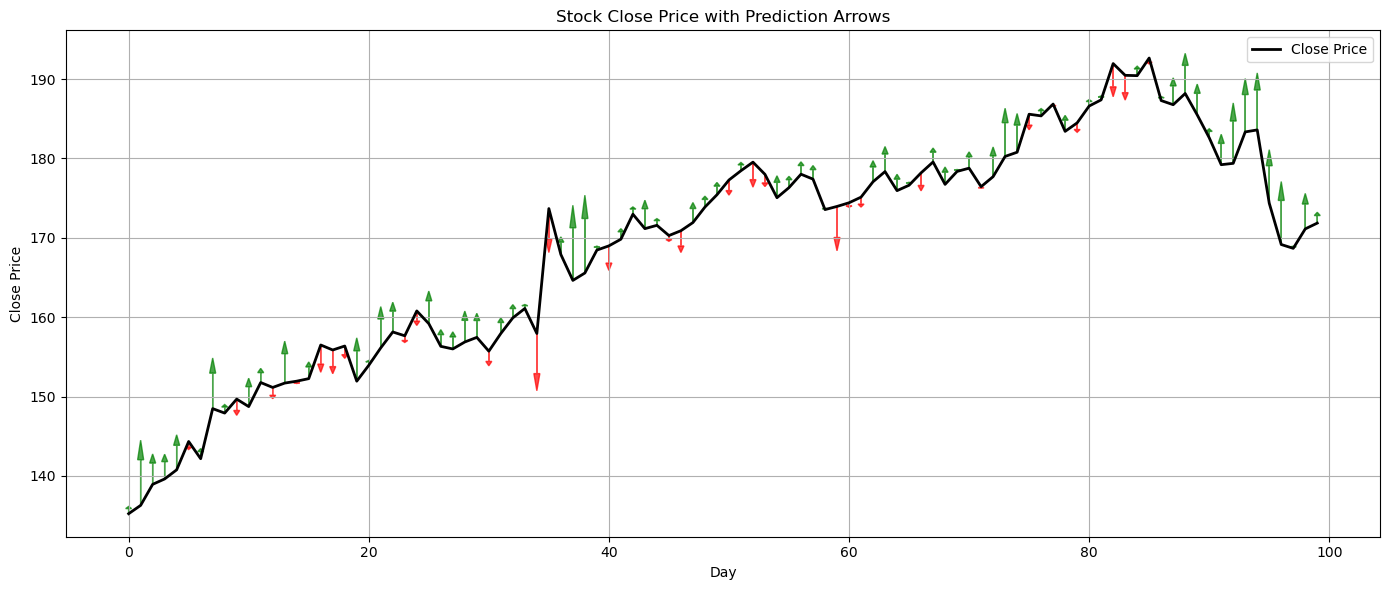

In [60]:
test_stock_data = pd.read_csv('./clean_data/GOOG.csv')
test_stock_data = test_stock_data.dropna()
test_stock_data['Date'] = pd.to_datetime(test_stock_data['Date'])
test_stock_data['Year'] = test_stock_data['Date'].dt.year
test_stock_data['Month'] = test_stock_data['Date'].dt.month
test_stock_data['Day'] = test_stock_data['Date'].dt.day
test_stock_data = test_stock_data.drop('Date', axis=1)
test_stock_data = test_stock_data.drop('Symbol', axis=1)
test_stock_data = test_stock_data.drop('Target', axis=1)
reg = LinearRegression()
reg.fit(X_train, y_train)

X_test = test_stock_data.drop(['Pct_Change'], axis=1)
y_test = test_stock_data['Pct_Change'][-200:-100]

y_pred = reg.predict(X_test[-200:-100])
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")


x = np.arange(100)  # x-axis as index
y = X_test['Close'][-200:-100].to_numpy() # closing prices
plt.figure(figsize=(14, 6))
plt.plot(x, y, label='Close Price', color='black', linewidth=2)

# Add arrows
for i in range(len(x)):
    arrow_length = y_pred[i] * 5000  # Scale to make arrows visible
    color = 'green' if y_pred[i] > 0 else 'red'
    
    plt.arrow(
        x[i], y[i],
        0, arrow_length,  # dx = 0, dy = scaled prediction
        color=color,
        head_width=0.5,
        head_length=abs(arrow_length) * 0.3,
        length_includes_head=True,
        alpha=0.7
    )

plt.title('Stock Close Price with Prediction Arrows')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

MSE: 0.00024433025353551156


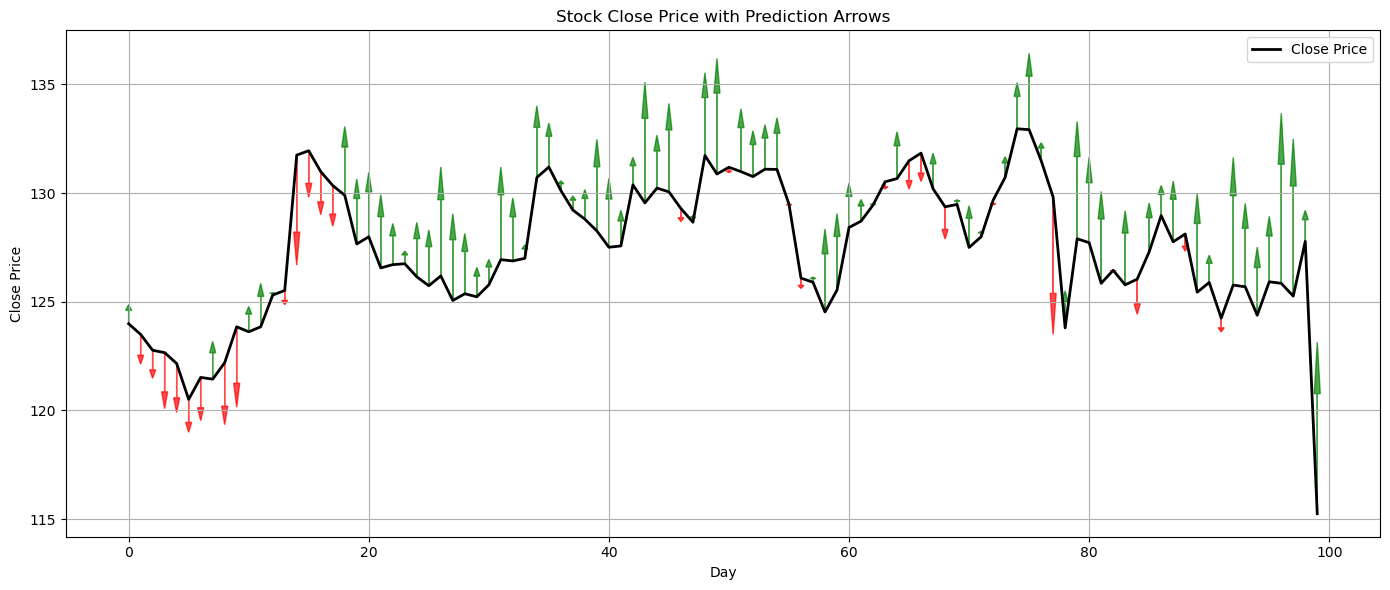

In [ ]:
test_stock_data = pd.read_csv('./clean_data/MRK.csv')
test_stock_data = test_stock_data.dropna()
test_stock_data['Date'] = pd.to_datetime(test_stock_data['Date'])
test_stock_data['Year'] = test_stock_data['Date'].dt.year
test_stock_data['Month'] = test_stock_data['Date'].dt.month
test_stock_data['Day'] = test_stock_data['Date'].dt.day
test_stock_data = test_stock_data.drop('Date', axis=1)
test_stock_data = test_stock_data.drop('Symbol', axis=1)
test_stock_data = test_stock_data.drop('Target', axis=1)
reg = LinearRegression()
reg.fit(X_train, y_train)

X_test = test_stock_data.drop(['Pct_Change'], axis=1)
y_test = test_stock_data['Pct_Change'][-200:-100]

y_pred = reg.predict(X_test[-200:-100])

x = np.arange(100)  # x-axis as index
y = X_test['Close'][-200:-100].to_numpy() # closing prices
plt.figure(figsize=(14, 6))
plt.plot(x, y, label='Close Price', color='black', linewidth=2)

# Add arrows
for i in range(len(x)):
    arrow_length = y_pred[i] * 5000  # Scale to make arrows visible
    color = 'green' if y_pred[i] > 0 else 'red'
    
    plt.arrow(
        x[i], y[i],
        0, arrow_length,  # dx = 0, dy = scaled prediction
        color=color,
        head_width=0.5,
        head_length=abs(arrow_length) * 0.3,
        length_includes_head=True,
        alpha=0.7
    )

plt.title('Stock Close Price with Prediction Arrows')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

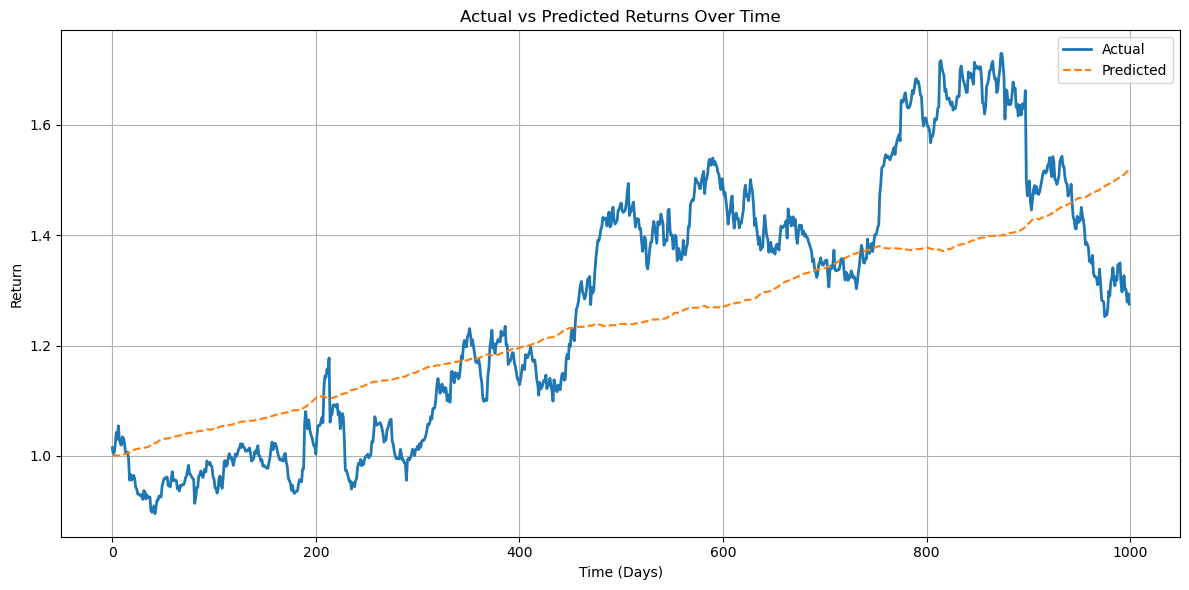

In [64]:
test_stock_data = pd.read_csv('./clean_data/MRK.csv')
test_stock_data = test_stock_data.dropna()
test_stock_data['Date'] = pd.to_datetime(test_stock_data['Date'])
test_stock_data['Year'] = test_stock_data['Date'].dt.year
test_stock_data['Month'] = test_stock_data['Date'].dt.month
test_stock_data['Day'] = test_stock_data['Date'].dt.day
test_stock_data = test_stock_data.drop('Date', axis=1)
test_stock_data = test_stock_data.drop('Symbol', axis=1)
test_stock_data = test_stock_data.drop('Target', axis=1)
reg = LinearRegression()
reg.fit(X_train, y_train)

X_test = test_stock_data.drop(['Pct_Change'], axis=1)

y_test = test_stock_data['Pct_Change'][-1000:]

y_pred = reg.predict(X_test[-1000:])

actual_cumulative = (1 + y_test).cumprod()
predicted_cumulative = (1 + y_pred).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(actual_cumulative.values, label="Actual", linewidth=2)
plt.plot(predicted_cumulative, label="Predicted", linestyle='--')
plt.title("Actual vs Predicted Returns Over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

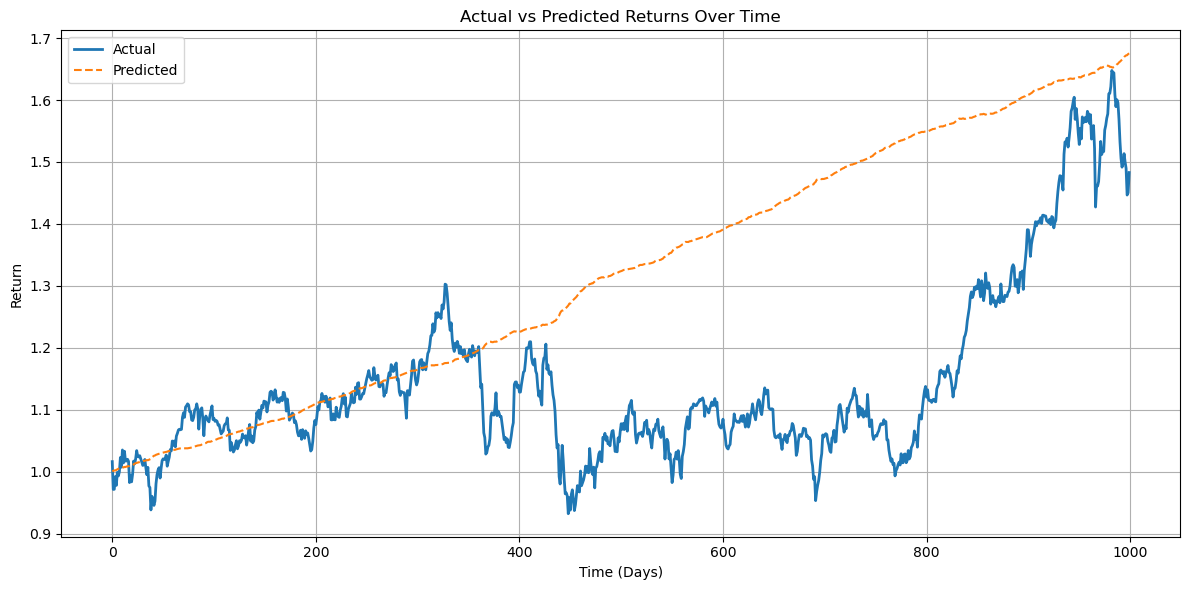

In [65]:
test_stock_data = pd.read_csv('./clean_data/PEG.csv')
test_stock_data = test_stock_data.dropna()
test_stock_data['Date'] = pd.to_datetime(test_stock_data['Date'])
test_stock_data['Year'] = test_stock_data['Date'].dt.year
test_stock_data['Month'] = test_stock_data['Date'].dt.month
test_stock_data['Day'] = test_stock_data['Date'].dt.day
test_stock_data = test_stock_data.drop('Date', axis=1)
test_stock_data = test_stock_data.drop('Symbol', axis=1)
test_stock_data = test_stock_data.drop('Target', axis=1)
reg = LinearRegression()
reg.fit(X_train, y_train)

X_test = test_stock_data.drop(['Pct_Change'], axis=1)

y_test = test_stock_data['Pct_Change'][-1000:]

y_pred = reg.predict(X_test[-1000:])

actual_cumulative = (1 + y_test).cumprod()
predicted_cumulative = (1 + y_pred).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(actual_cumulative.values, label="Actual", linewidth=2)
plt.plot(predicted_cumulative, label="Predicted", linestyle='--')
plt.title("Actual vs Predicted Returns Over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

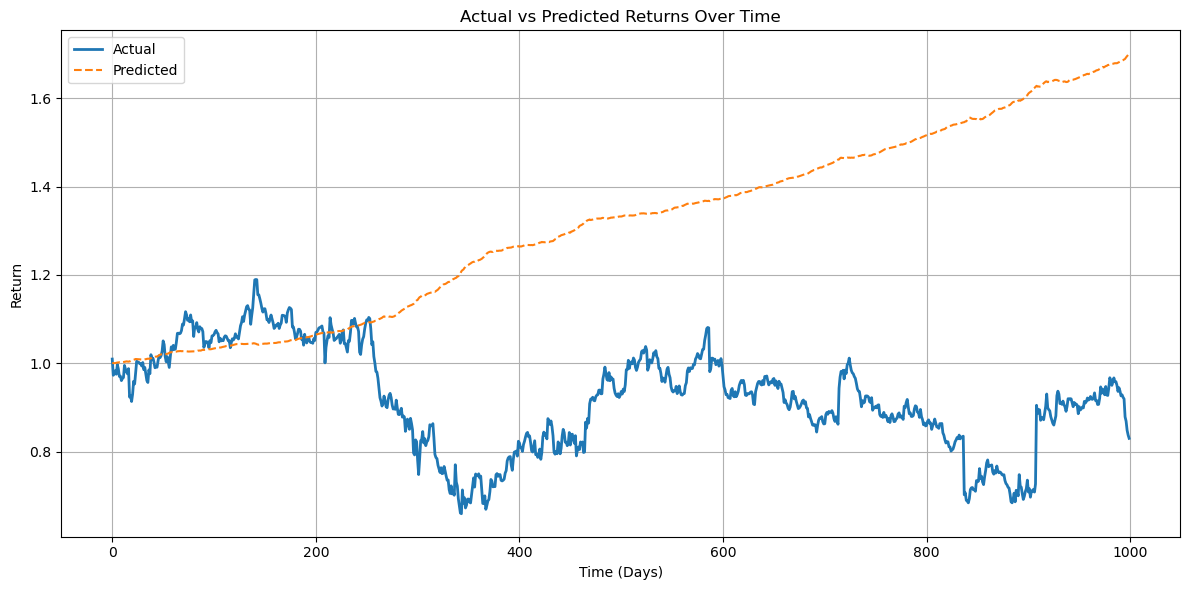

In [ ]:
test_stock_data = pd.read_csv('./clean_data/SBUX.csv')
test_stock_data = test_stock_data.dropna()
test_stock_data['Date'] = pd.to_datetime(test_stock_data['Date'])
test_stock_data['Year'] = test_stock_data['Date'].dt.year
test_stock_data['Month'] = test_stock_data['Date'].dt.month
test_stock_data['Day'] = test_stock_data['Date'].dt.day
test_stock_data = test_stock_data.drop('Date', axis=1)
test_stock_data = test_stock_data.drop('Symbol', axis=1)
test_stock_data = test_stock_data.drop('Target', axis=1)
reg = LinearRegression()
reg.fit(X_train, y_train)

X_test = test_stock_data.drop(['Pct_Change'], axis=1)

y_test = test_stock_data['Pct_Change'][-1000:]

y_pred = reg.predict(X_test[-1000:])

actual_cumulative = (1 + y_test).cumprod()
predicted_cumulative = (1 + y_pred).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(actual_cumulative.values, label="Actual", linewidth=2)
plt.plot(predicted_cumulative, label="Predicted", linestyle='--')
plt.title("Actual vs Predicted Returns Over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [167]:
stock_data = pd.read_csv('./merged_data.csv')
stock_data = stock_data.dropna()
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['Year'] = stock_data['Date'].dt.year
stock_data['Month'] = stock_data['Date'].dt.month
stock_data['Day'] = stock_data['Date'].dt.day
stock_data = stock_data.drop('Date', axis=1)
stock_data = stock_data.drop('Symbol', axis=1)
stock_data = stock_data.drop('Ticker', axis=1)
stock_data = stock_data.drop('Target', axis=1)

X = stock_data.drop(['Pct_Change'], axis=1)
y = stock_data['Pct_Change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

/var/folders/8q/pd8bhfh923x7_5hc541qy_8c0000gn/T/ipykernel_65096/1444059765.py:3: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


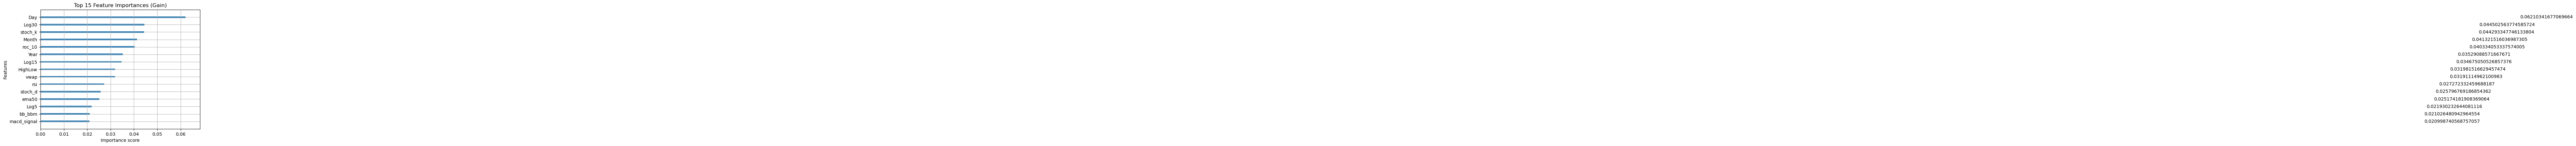

In [168]:
plot_importance(xgb, importance_type='gain', max_num_features=15)
plt.title("Top 15 Feature Importances (Gain)")
plt.tight_layout()
plt.show()

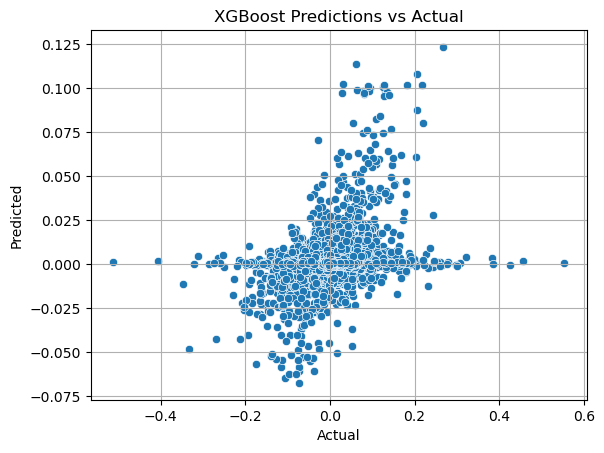

In [169]:
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost Predictions vs Actual")
plt.grid(True)
plt.show()

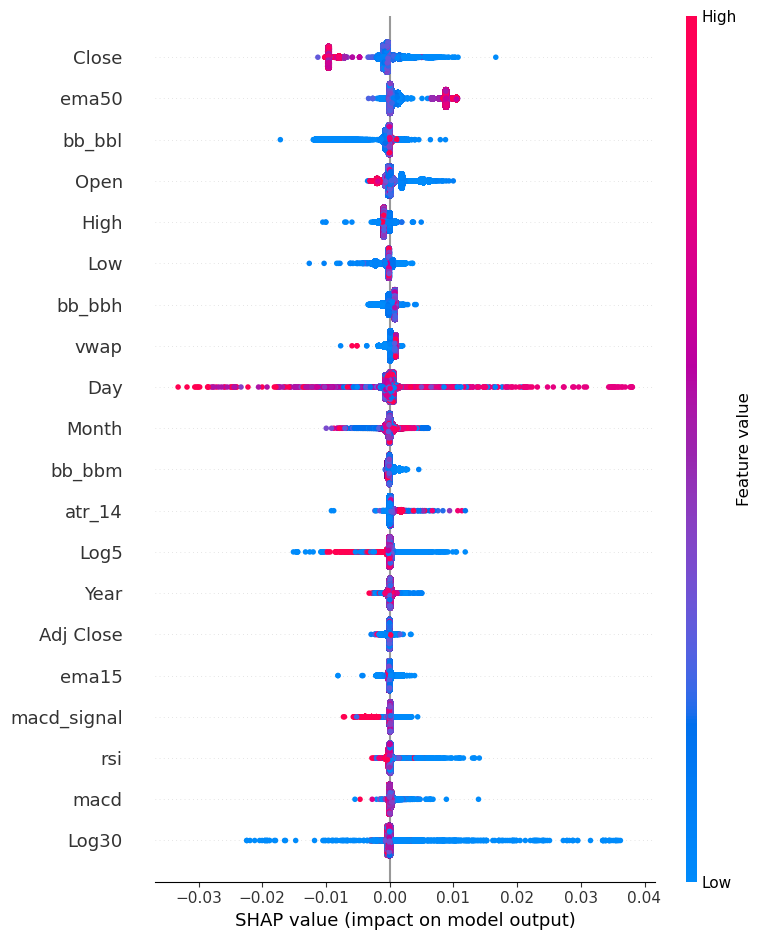

In [170]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

In [171]:
scores = cross_val_score(xgb, X, y, cv=5, scoring='neg_mean_squared_error')
print("RMSE:", (-scores.mean())**0.5)

RMSE: 0.019601431851785586


In [172]:
stock_data = pd.read_csv('./merged_data.csv')
stock_data = stock_data.dropna()
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
last_year_data = stock_data[stock_data['Date'] >= '2024-04-01']
last_year_data = last_year_data.drop('Ticker', axis=1)

X_last_year = last_year_data.drop(['Pct_Change', 'Date', 'Target', 'Symbol'], axis=1)
y_last_year = last_year_data['Pct_Change']  # actual % change (daily return)

X_train, X_test, y_train, y_test = train_test_split(X_last_year, y_last_year, test_size=0.25)
reg = LinearRegression()
reg.fit(X_train, y_train)

predicted_returns = reg.predict(X_last_year)

In [173]:
initial_cash = 10000
threshold = 0.003
portfolio_history = {}
symbols = last_year_data['Symbol'].unique()
for symbol in symbols:
    symbol_df = last_year_data[last_year_data['Symbol'] == symbol].copy()
    X = symbol_df.drop(['Date', 'Symbol', 'Target', 'Pct_Change'], axis=1)
    y = symbol_df['Pct_Change']
    dates = symbol_df['Date'].values

    preds = reg.predict(X)

    cash = initial_cash
    returns = []

    for pred, actual in zip(preds, y):
        if pred > threshold:
            cash *= (1 + actual)
        returns.append(cash)

    portfolio_history[symbol] = (dates, returns)

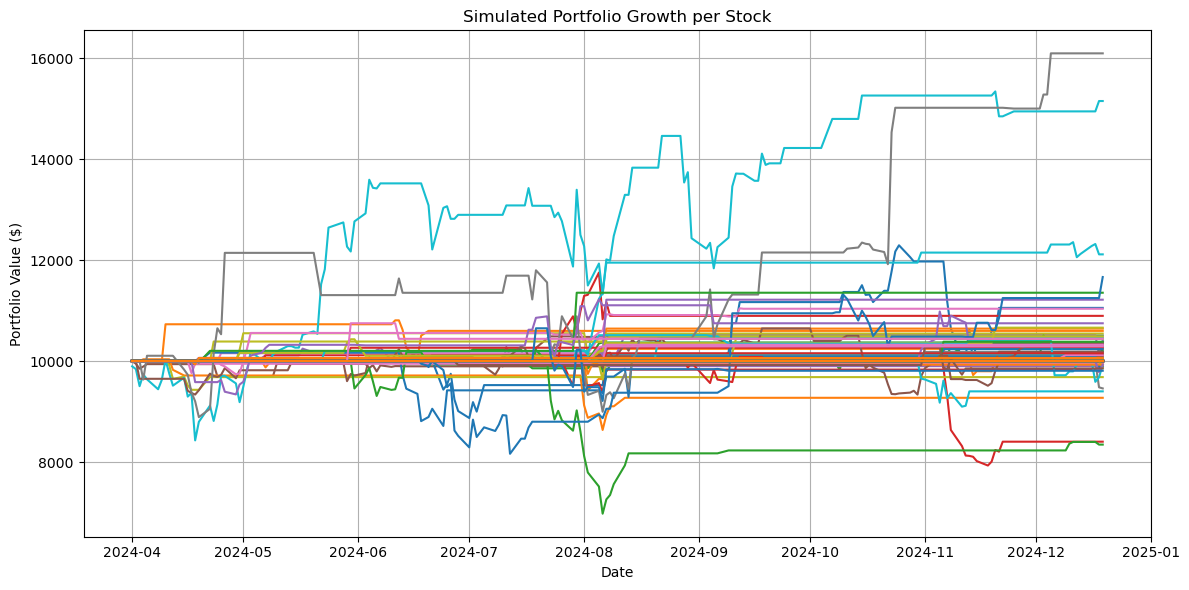

In [174]:
plt.figure(figsize=(12, 6))
for symbol, (dates, returns) in portfolio_history.items():
    plt.plot(dates, returns, label=symbol)

plt.title("Simulated Portfolio Growth per Stock")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [175]:
successes = 0
losses = 0
no_trades = 0
total_change = 0
for symbol, (dates, returns) in portfolio_history.items():
    total_change += returns[-1] - 10000
    if returns[-1] > 10000:
        successes += 1
    elif returns[-1] < 10000:
        losses += 1
    elif returns[-1] == 10000:
        no_trades += 1
print(successes, losses, no_trades, len(portfolio_history.items()))
print(total_change)

54 17 101 172
27471.996336059292


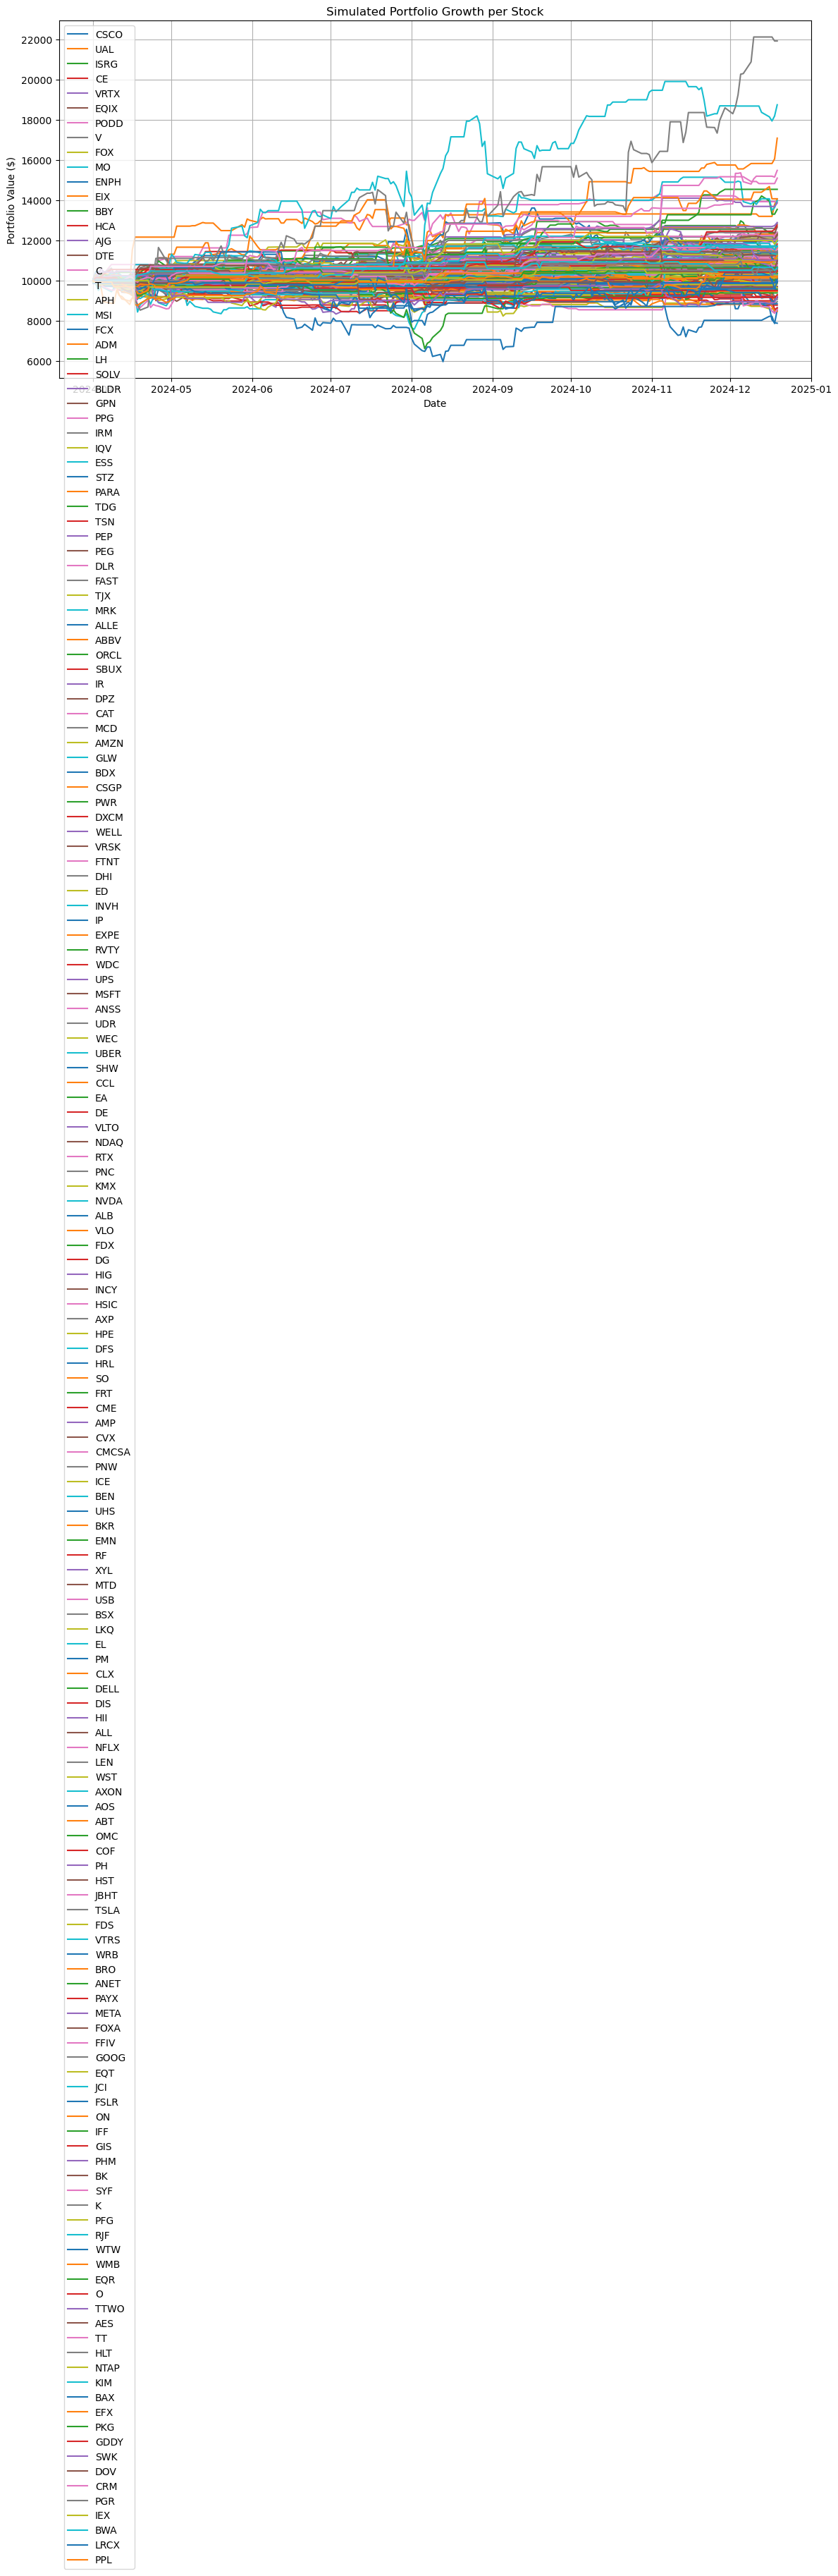

125 47 0 172
152849.25780679923


In [ ]:
initial_cash = 10000
threshold = 0.001
portfolio_history = {}
symbols = last_year_data['Symbol'].unique()
for symbol in symbols:
    symbol_df = last_year_data[last_year_data['Symbol'] == symbol].copy()
    X = symbol_df.drop(['Date', 'Symbol', 'Target', 'Pct_Change'], axis=1)
    y = symbol_df['Pct_Change']
    dates = symbol_df['Date'].values

    preds = reg.predict(X)

    cash = initial_cash
    returns = []

    for pred, actual in zip(preds, y):
        if pred > threshold:
            cash *= (1 + actual)
        returns.append(cash)

    portfolio_history[symbol] = (dates, returns)
plt.figure(figsize=(12, 6))
for symbol, (dates, returns) in portfolio_history.items():
    plt.plot(dates, returns, label=symbol)

plt.title("Simulated Portfolio Growth per Stock")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()
successes = 0
losses = 0
no_trades = 0
total_change = 0
for symbol, (dates, returns) in portfolio_history.items():
    total_change += returns[-1] - 10000
    if returns[-1] > 10000:
        successes += 1
    elif returns[-1] < 10000:
        losses += 1
    elif returns[-1] == 10000:
        no_trades += 1
print(successes, losses, no_trades, len(portfolio_history.items()))
print(total_change)

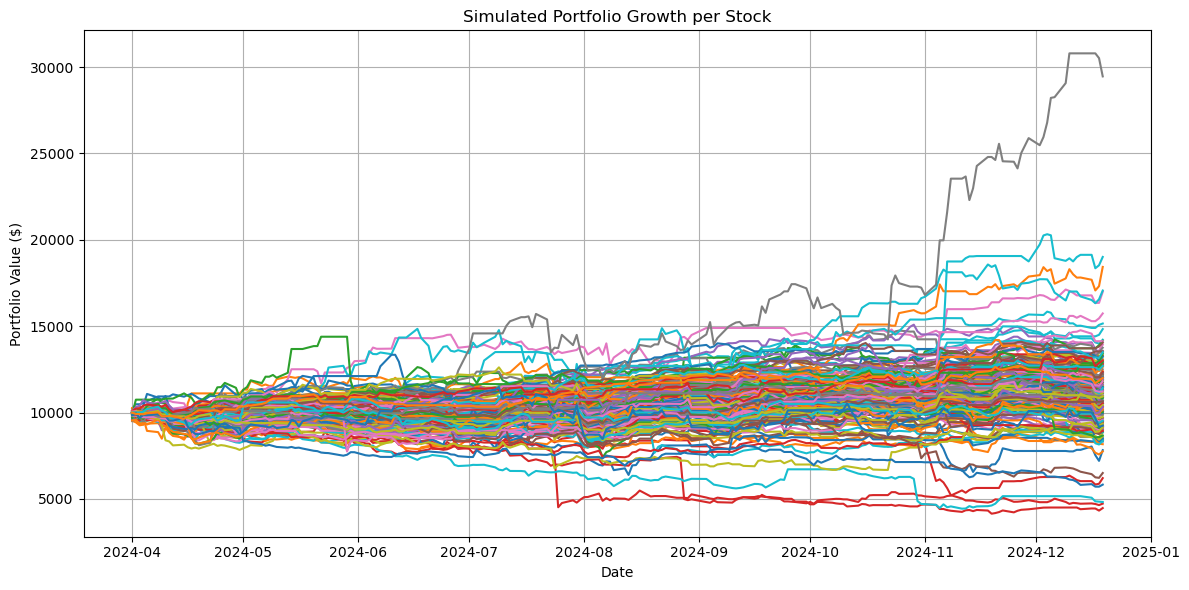

120 52 0 172
193442.01114190958


In [178]:
initial_cash = 10000
threshold = 0.000
portfolio_history = {}
symbols = last_year_data['Symbol'].unique()
for symbol in symbols:
    symbol_df = last_year_data[last_year_data['Symbol'] == symbol].copy()
    X = symbol_df.drop(['Date', 'Symbol', 'Target', 'Pct_Change'], axis=1)
    y = symbol_df['Pct_Change']
    dates = symbol_df['Date'].values

    preds = reg.predict(X)

    cash = initial_cash
    returns = []

    for pred, actual in zip(preds, y):
        if pred > threshold:
            cash *= (1 + actual)
        returns.append(cash)

    portfolio_history[symbol] = (dates, returns)
plt.figure(figsize=(12, 6))
for symbol, (dates, returns) in portfolio_history.items():
    plt.plot(dates, returns, label=symbol)

plt.title("Simulated Portfolio Growth per Stock")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()
successes = 0
losses = 0
no_trades = 0
total_change = 0
for symbol, (dates, returns) in portfolio_history.items():
    total_change += returns[-1] - 10000
    if returns[-1] > 10000:
        successes += 1
    elif returns[-1] < 10000:
        losses += 1
    elif returns[-1] == 10000:
        no_trades += 1
print(successes, losses, no_trades, len(portfolio_history.items()))
print(total_change)

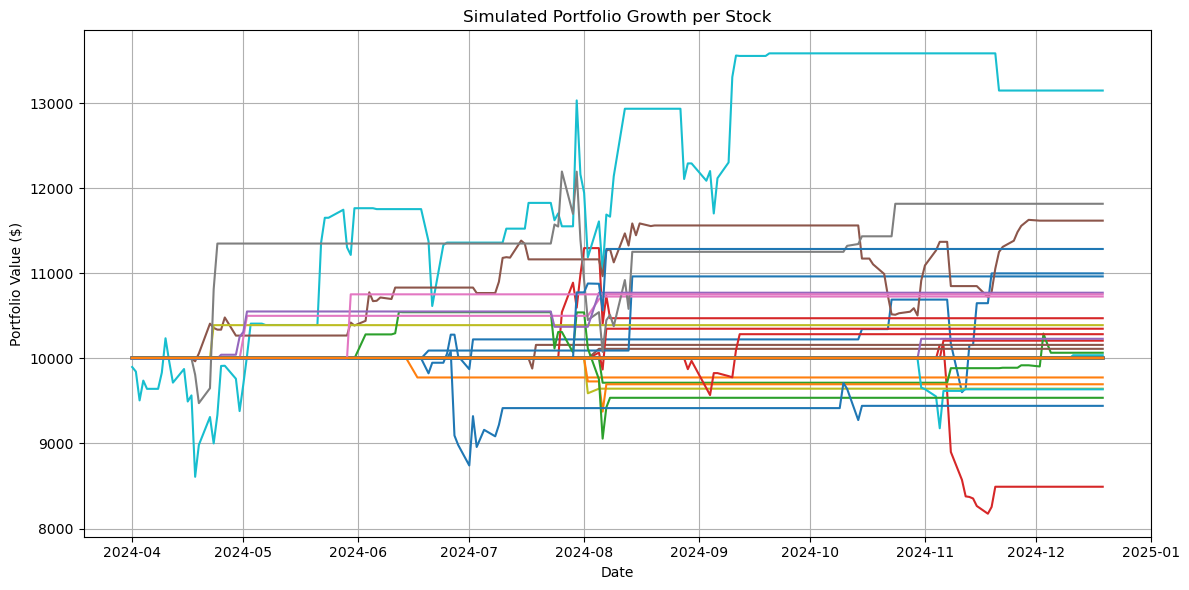

19 7 146 172
10631.747100024033


In [179]:
initial_cash = 10000
threshold = 0.005
portfolio_history = {}
symbols = last_year_data['Symbol'].unique()
for symbol in symbols:
    symbol_df = last_year_data[last_year_data['Symbol'] == symbol].copy()
    X = symbol_df.drop(['Date', 'Symbol', 'Target', 'Pct_Change'], axis=1)
    y = symbol_df['Pct_Change']
    dates = symbol_df['Date'].values

    preds = reg.predict(X)

    cash = initial_cash
    returns = []

    for pred, actual in zip(preds, y):
        if pred > threshold:
            cash *= (1 + actual)
        returns.append(cash)

    portfolio_history[symbol] = (dates, returns)
plt.figure(figsize=(12, 6))
for symbol, (dates, returns) in portfolio_history.items():
    plt.plot(dates, returns, label=symbol)

plt.title("Simulated Portfolio Growth per Stock")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()
successes = 0
losses = 0
no_trades = 0
total_change = 0
for symbol, (dates, returns) in portfolio_history.items():
    total_change += returns[-1] - 10000
    if returns[-1] > 10000:
        successes += 1
    elif returns[-1] < 10000:
        losses += 1
    elif returns[-1] == 10000:
        no_trades += 1
print(successes, losses, no_trades, len(portfolio_history.items()))
print(total_change)

In [184]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA, GOOG

/Users/emccauley6/anaconda3/lib/python3.11/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [212]:
stock_data = pd.read_csv('./merged_data.csv')
stock_data = stock_data.dropna()
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['Year'] = stock_data['Date'].dt.year
stock_data['Month'] = stock_data['Date'].dt.month
stock_data['Day'] = stock_data['Date'].dt.day
stock_data = stock_data.drop('Date', axis=1)
stock_data = stock_data.drop('Symbol', axis=1)
stock_data = stock_data.drop('Ticker', axis=1)
stock_data = stock_data.drop('Target', axis=1)

X = stock_data.drop(['Pct_Change'], axis=1)
y = stock_data['Pct_Change']

GOOG_data = pd.read_csv('./clean_data/GOOG.csv')
GOOG_data['Date'] = pd.to_datetime(GOOG_data['Date'])
GOOG_data['Year'] = GOOG_data['Date'].dt.year
GOOG_data['Month'] = GOOG_data['Date'].dt.month
GOOG_data['Day'] = GOOG_data['Date'].dt.day
GOOG_data = GOOG_data.drop('Target', axis=1)
X_test = GOOG_data.drop('Date', axis=1)
X_test = X_test.drop('Symbol', axis=1)
X_test = X_test.drop('Pct_Change', axis=1)
X_test = X_test[-1000:]
y_test = GOOG_data['Pct_Change'][-1000:]

reg = LinearRegression()
reg.fit(X, y)

y_pred = reg.predict(X_test)

y_pred_series = pd.Series(y_pred, index=X_test.index, name='Prediction')
GOOG = pd.concat([X_test, y_pred_series], axis=1)


In [213]:
GOOG.head()

,Adj Close,Close,High,Low,Open,Volume,ema15,ema50,macd,macd_signal,...,Clopen,HighLow,log_price,Log5,Log15,Log30,Year,Month,Day,Prediction
2768,87.280396,87.594002,87.946503,86.771004,86.771004,20238000.0,87.732908,86.013080,0.057685,0.309203,...,1.009485,1.013547,4.472713,0.011193,-0.018241,-0.010375,2020,12,31,0.000552
2769,86.102631,86.412003,88.032501,85.392502,87.876999,38038000.0,87.567794,86.028724,-0.045457,0.238271,...,0.983329,1.030916,4.459127,-0.006120,-0.026883,-0.010670,2021,1,4,0.000142
2770,86.734360,87.045998,87.383499,85.900749,86.250000,22906000.0,87.502570,86.068617,-0.075174,0.175582,...,1.009229,1.017261,4.466437,-0.020001,-0.023194,-0.013125,2021,1,5,0.000465
2771,86.453857,86.764503,87.400002,84.949997,85.131500,52042000.0,87.410312,86.095907,-0.120055,0.116455,...,1.019182,1.028841,4.463198,-0.013412,-0.014173,-0.003968,2021,1,6,0.000207
2772,89.042557,89.362503,89.419998,86.852501,87.002998,45300000.0,87.654336,86.224008,0.053398,0.103843,...,1.027120,1.029562,4.492701,0.027069,0.010959,0.029751,2021,1,7,0.000444


In [223]:
class Strat(Strategy):

    def init(self):
        self.pred = self.data.df['Prediction'].values

    def next(self):
        i = len(self.data.Close) - 1
        prediction = self.pred[i]
        threshold = 0.0005

        if prediction > threshold and not self.position:
            self.buy()
        elif prediction < -threshold and self.position:
            self.position.close()


bt = Backtest(GOOG, Strat,
              cash=10000, commission=.002,
              exclusive_orders=True)

output = bt.run()
bt.plot()

/var/folders/8q/pd8bhfh923x7_5hc541qy_8c0000gn/T/ipykernel_65096/1924267558.py:17: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(GOOG, Strat,


Backtest.run:   0%|          | 0/999 [00:00<?, ?bar/s]

GridPlot(id='p3753', ...)